In [345]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='06da6cb9-f521-4637-8e87-58eebbd84d75', project_access_token='p-2+ha5jHooHijO2exOzS6WcdQ==;n/2/fdaCyiJw+mTCb/yDzg==:esPOqW4sNpWgURM0YeFi8Px2AdS25FkJVceNpUlMHPcWajXPslWcDUGhuaV1nk+DgQhZEKSRygp/eG8WccPYajZkNL0KSrQEnA==')
pc = project.project_context

from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space({'token':'p-2+ha5jHooHijO2exOzS6WcdQ==;n/2/fdaCyiJw+mTCb/yDzg==:esPOqW4sNpWgURM0YeFi8Px2AdS25FkJVceNpUlMHPcWajXPslWcDUGhuaV1nk+DgQhZEKSRygp/eG8WccPYajZkNL0KSrQEnA=='})



In [346]:
!pip install natsort
!pip install tensorflow_datasets

In [347]:
#imports
from zipfile import ZipFile
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import io
import numpy as np
import random
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from pathlib import Path

import sklearn
from sklearn.model_selection import train_test_split

In [348]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='MeIrYdYxQFxlcIiqQ5Bq3H2txwCwhhNgOfhZqmj7293w',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'skincancer-donotdelete-pr-mcwsmgkoxtaa7r'
object_key = 'preprocessed.zip'

streaming_body_2 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']


In [349]:
# auxiliary function that you are already familiar with
import zipfile
def get_zip(file_name):
    '''
    file_name = Name of zip file you want to download from object storage
    '''
    try:
        fobj = open(file_name, "wb")
        fobj.write(project.get_file(file_name).read()) 
        fobj.close()
        z = zipfile.ZipFile(file_name)
        z.extractall()
    except Exception as e:
        print(Exception,e)
    else:
        print('Files downloaded successfully')


In [350]:
!rm -rf cancer
!rm -rf preprocessed

In [351]:
!ls

efficient_net_weights				efficient_net_weights.zip
efficient_net_weights_transfer_undersample.zip	preprocessed.zip


In [352]:
get_zip('preprocessed.zip')

Files downloaded successfully


In [353]:
!ls 

efficient_net_weights				preprocessed
efficient_net_weights_transfer_undersample.zip	preprocessed.zip
efficient_net_weights.zip


# Creating tensorflow dataset

In [357]:
metadata_csv = cos_client.get_object(Bucket=bucket, Key='cancer_metadata.csv')['Body']
metadata = pd.read_csv(metadata_csv)
metadata.columns

/tmp/wsuser/ipykernel_273/2932992292.py:2: DtypeWarning: Columns (8,11,12,15,17,18,22) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadata_csv)


Index(['isic_id', 'attribution', 'copyright_license', 'acquisition_day',
       'age_approx', 'anatom_site_general', 'benign_malignant',
       'clin_size_long_diam_mm', 'dermoscopic_type', 'diagnosis',
       'diagnosis_confirm_type', 'family_hx_mm', 'image_type', 'lesion_id',
       'mel_class', 'mel_mitotic_index', 'mel_thick_mm', 'mel_type',
       'mel_ulcer', 'melanocytic', 'nevus_type', 'patient_id',
       'personal_hx_mm', 'pixels_x', 'pixels_y', 'sex'],
      dtype='object')

In [358]:
benign_count = len(metadata[ metadata['benign_malignant'] == 'benign'])
malignant_count = len(metadata[ metadata['benign_malignant'] == 'malignant'])
malignant_frac = malignant_count / (benign_count + malignant_count) * 100

print(benign_count)
print(malignant_count)
print(malignant_frac)


32542
584
1.762965646320111


In [359]:
benign = metadata[metadata['benign_malignant'] == 'benign']
benign = benign.sample(frac=0.1) # this line undersamples the dataset
malignant = metadata[metadata['benign_malignant'] == 'malignant']
metadata = pd.concat([benign,malignant])
f = 0.2
train_df, test_df = train_test_split(metadata, test_size=f)
train_df, val_df = train_test_split(train_df, test_size=f)


benign_count = len(train_df[ train_df['benign_malignant'] == 'benign'])
malignant_count = len(train_df[ train_df['benign_malignant'] == 'malignant'])
malignant_frac = malignant_count / (benign_count + malignant_count) * 100

print(f"Benign: {benign_count}")
print(f"Malignant: {malignant_count}")
print(f"Malignant fraction: {malignant_frac:.2f}%")

Benign: 2087
Malignant: 369
Malignant fraction: 15.02%


In [360]:
benign_count = len(val_df[ val_df['benign_malignant'] == 'benign'])
malignant_count = len(val_df[ val_df['benign_malignant'] == 'malignant'])
malignant_frac = malignant_count / (benign_count + malignant_count) * 100

print(f"Benign: {benign_count}")
print(f"Malignant: {malignant_count}")
print(f"Malignant fraction: {malignant_frac:.2f}%")

Benign: 523
Malignant: 91
Malignant fraction: 14.82%


In [361]:
benign_count = len(test_df[ test_df['benign_malignant'] == 'benign'])
malignant_count = len(test_df[ test_df['benign_malignant'] == 'malignant'])
malignant_frac = malignant_count / (benign_count + malignant_count) * 100

print(f"Benign: {benign_count}")
print(f"Malignant: {malignant_count}")
print(f"Malignant fraction: {malignant_frac:.2f}%")

Benign: 644
Malignant: 124
Malignant fraction: 16.15%


In [312]:
train_df

,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,dermoscopic_type,diagnosis,...,mel_thick_mm,mel_type,mel_ulcer,melanocytic,nevus_type,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
9291,ISIC_5921024,The University of Queensland Diamantina Instit...,CC-BY,1.0,70.0,lower extremity,benign,NaN,contact non-polarized,NaN,...,NaN,NaN,NaN,NaN,NaN,IP_1036531,False,6000,4000,male
31463,ISIC_1768197,MSKCC,CC-BY-NC,NaN,40.0,lower extremity,benign,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,IP_0307863,NaN,6000,4000,male
25027,ISIC_9467322,MSKCC,CC-BY-NC,NaN,30.0,head/neck,benign,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,IP_0776416,NaN,3264,2448,female
30767,ISIC_5657291,MSKCC,CC-BY-NC,NaN,65.0,posterior torso,benign,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,IP_6512345,NaN,4288,2848,male
22351,ISIC_1261939,MSKCC,CC-BY-NC,NaN,60.0,head/neck,benign,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,IP_7404937,NaN,6000,4000,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5742,ISIC_3492490,"Department of Dermatology, Hospital Clínic de ...",CC-BY-NC,NaN,40.0,upper extremity,benign,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,IP_7368120,NaN,640,480,female
31734,ISIC_5918517,MSKCC,CC-BY-NC,NaN,35.0,posterior torso,benign,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,IP_0039318,NaN,6000,4000,male
32932,ISIC_7035517,MSKCC,CC-BY-NC,NaN,70.0,upper extremity,benign,NaN,NaN,nevus,...,NaN,NaN,NaN,True,NaN,IP_7335423,NaN,3264,2448,female
7424,ISIC_7614221,Pascale Guitera,CC-BY-NC,104.0,30.0,posterior torso,malignant,NaN,NaN,melanoma,...,NaN,superficial spreading melanoma,NaN,True,NaN,IP_9942136,NaN,5184,3456,male


In [314]:
import shutil
import os

def local_filename(row):
    return row['isic_id'] + ".JPG"

def download_df(df, folder="cancer"):

    def save_image(img_name, path_prefix, source_folder="preprocessed"):
        src_filepath = os.path.join(source_folder, img_name)
        dest_filepath = os.path.join(path_prefix, img_name)
        shutil.copy2(src_filepath, dest_filepath)

    benin = df[df['benign_malignant'] == 'benign']
    malignat = df[df['benign_malignant'] == 'malignant']

    benin_filenames = benin.apply(local_filename, axis=1)
    malignat_filenames = malignat.apply(local_filename, axis=1)

    p = os.path.join(folder, "")
    os.makedirs(p, exist_ok=True)
    benin_path = os.path.join(p, 'benign')
    os.makedirs(benin_path, exist_ok=True)
    malignat_path = os.path.join(p, 'malignant')
    os.makedirs(malignat_path, exist_ok=True)

    for img_name in benin_filenames:
        save_image(img_name, benin_path)

    for img_name in malignat_filenames:
        save_image(img_name, malignat_path)

In [354]:
download_df(train_df, "cancer/train")

In [355]:
download_df(val_df, "cancer/val")

In [356]:
download_df(test_df, "cancer/test")

In [266]:
!ls -l cancer/train/benign

total 87732
-rw-rw---- 1 wsuser wscommon 40775 Jun 19 19:45 ISIC_0076995.JPG
-rw-rw---- 1 wsuser wscommon 41896 Jun 19 19:45 ISIC_0078712.JPG
-rw-rw---- 1 wsuser wscommon 37218 Jun 19 19:45 ISIC_0083035.JPG
-rw-rw---- 1 wsuser wscommon 40487 Jun 19 19:45 ISIC_0084086.JPG
-rw-rw---- 1 wsuser wscommon 35521 Jun 19 19:45 ISIC_0085902.JPG
-rw-rw---- 1 wsuser wscommon 31048 Jun 19 19:45 ISIC_0088137.JPG
-rw-rw---- 1 wsuser wscommon 47916 Jun 19 19:45 ISIC_0091016.JPG
-rw-rw---- 1 wsuser wscommon 38227 Jun 19 19:45 ISIC_0091996.JPG
-rw-rw---- 1 wsuser wscommon 43400 Jun 19 19:45 ISIC_0094755.JPG
-rw-rw---- 1 wsuser wscommon 43507 Jun 19 19:45 ISIC_0109415.JPG
-rw-rw---- 1 wsuser wscommon 34366 Jun 19 19:45 ISIC_0109869.JPG
-rw-rw---- 1 wsuser wscommon 40028 Jun 19 19:45 ISIC_0148783.JPG
-rw-rw---- 1 wsuser wscommon 52521 Jun 19 19:45 ISIC_0156460.JPG
-rw-rw---- 1 wsuser wscommon 41196 Jun 19 19:45 ISIC_0157923.JPG
-rw-rw---- 1 wsuser wscommon 41138 Jun 19 19:45 ISIC_0158127.JPG
-rw-rw---- 1 

Code for resampling

In [267]:
import shutil

def copy_resampled_images(resampled_df, path):
    pos_features =  resampled_df[ resampled_df['benign_malignant'] == 'malignant']
    img_names = pos_features.apply(bucket_filename, axis=1)
    
    p = Path(path)
    
    for (img_name, count) in img_names.groupby(img_names).count().items():
        orig_img = p / img_name
        for i in range(count-1):
            copied_name = str(orig_img) + "_" + str(i)
            shutil.copy2(orig_img, copied_name)

In [268]:
# copy_resampled_images(res_df, "cancer/train/malignant")

In [269]:
!ls -l cancer/

total 12
drwxrwx--- 4 wsuser wscommon 4096 Jun 19 19:46 test
drwxrwx--- 4 wsuser wscommon 4096 Jun 19 19:46 train
drwxrwx--- 4 wsuser wscommon 4096 Jun 19 19:46 val


Tensorflow datasets

In [362]:
img_height, img_width = 240, 240
# img_height, img_width = 224, 224
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "cancer/train",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary')

val_ds = tf.keras.utils.image_dataset_from_directory(
    "cancer/val",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary')

test_ds = tf.keras.utils.image_dataset_from_directory(
    "cancer/test",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    label_mode='binary')


Found 2456 files belonging to 2 classes.
Found 614 files belonging to 2 classes.
Found 768 files belonging to 2 classes.


In [271]:
class_names = train_ds.class_names
print(class_names)


['benign', 'malignant']


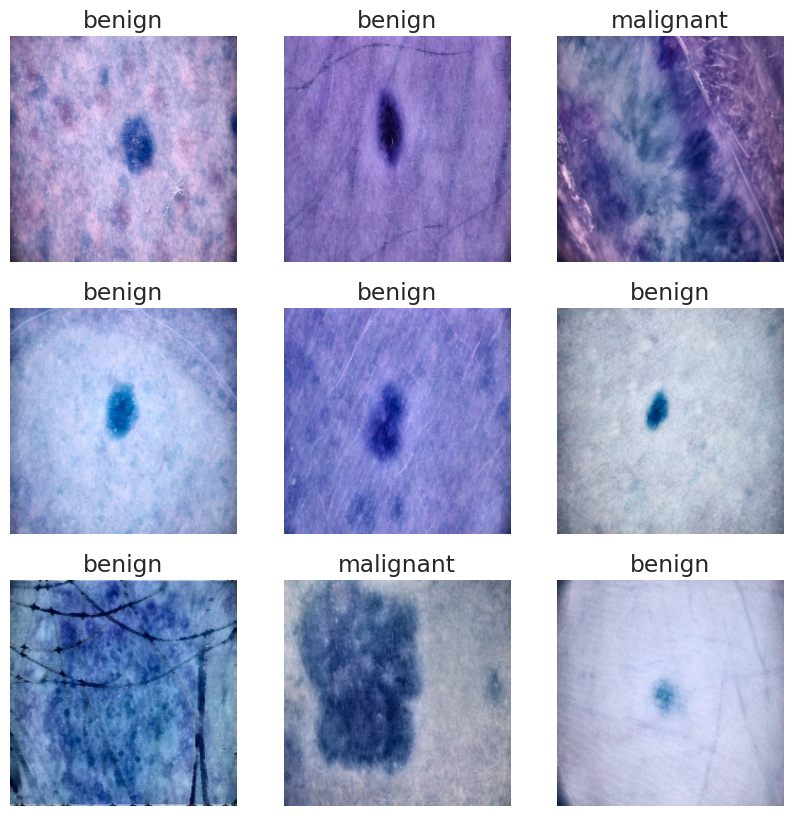

In [272]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i] > 0.5)])
    plt.axis("off")


In [363]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Transfer learning

In [366]:
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def get_model():
    

    neg = len(metadata[ metadata['benign_malignant'] == 'benign'])
    pos = len(metadata[ metadata['benign_malignant'] == 'malignant'])
    total = neg + pos
    initial_bias = np.log([pos/neg]) # help with loss convergence

    # rebalancing weights to account for class imbalance
    # for undersampling multiply negative weights by undersampling factor
    # weight_for_0 = (1 / neg) * (total / 2.0) * 10.0
    # weight_for_1 = (1 / pos) * (total / 2.0)

    weight_for_0 = 1
    weight_for_1 = 0.1

    print(f"weight for 0: {weight_for_0}")
    print(f"weight for 1: {weight_for_1}")

    class_weight = {0: weight_for_0, 1: weight_for_1}


    bias_initializer = tf.keras.initializers.Constant(initial_bias)

    METRICS = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
          keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]


    #Image augmentations
    img_augmentation = Sequential(
        [
            layers.RandomRotation(factor=0.15),
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
            layers.RandomFlip(),
            layers.RandomContrast(factor=0.1),
        ],
        name="img_augmentation",
    )


    # Model building
    inputs = layers.Input(shape=(img_height, img_width, 3))
    x = img_augmentation(inputs)
    model = eff_model = EfficientNetB1(
        include_top=False,
        weights='imagenet',
        input_tensor=x
      )

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="max_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    # add additional dense layer
    x = keras.layers.Dense(
              16, activation='relu')(x)
    # outputs = layers.Dense(1, activation="sigmoid", name="pred", bias_initializer = bias_initializer)(x)
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)


    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS
    )
    return model

model = get_model()

# list(map(lambda x: x.name, model.layers[-34:]))

weight for 0: 1
weight for 1: 0.1


In [277]:
def plot_hist(hist):
    plt.plot(hist.history["binary_accuracy"])
    plt.plot(hist.history["val_binary_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


In [367]:
epochs = 50


# add early stopping to avoid overfitting

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


hist = model.fit(
    train_ds, 
#     steps_per_epoch=20, 
    epochs=epochs,
    validation_data=val_ds, 
    callbacks = [early_stopping],
    verbose=2,
    class_weight = class_weight
)
# plot_hist(hist)


Epoch 1/50
77/77 - 41s - loss: 0.2360 - tp: 42.0000 - fp: 191.0000 - tn: 1883.0000 - fn: 340.0000 - accuracy: 0.7838 - precision: 0.1803 - recall: 0.1099 - auc: 0.5696 - prc: 0.1810 - val_loss: 0.4206 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 531.0000 - val_fn: 83.0000 - val_accuracy: 0.8648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4678 - val_prc: 0.1275 - 41s/epoch - 537ms/step
Epoch 2/50
77/77 - 27s - loss: 0.0840 - tp: 5.0000 - fp: 5.0000 - tn: 2069.0000 - fn: 377.0000 - accuracy: 0.8445 - precision: 0.5000 - recall: 0.0131 - auc: 0.6699 - prc: 0.2853 - val_loss: 0.4154 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 531.0000 - val_fn: 83.0000 - val_accuracy: 0.8648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5470 - val_prc: 0.1709 - 27s/epoch - 346ms/step
Epoch 3/50
77/77 - 27s - loss: 0.0793 - tp: 3.0000 - fp: 3.0000 - tn: 2071.0000 - fn: 379.0000 - accuracy: 0.8445 - precision: 0.5000 - recall: 0.0079 - auc: 0.6927 - pr

In [369]:
list(map(lambda x: x.name, model.layers[-37:]))

['block6e_add',
 'block7a_expand_conv',
 'block7a_expand_bn',
 'block7a_expand_activation',
 'block7a_dwconv',
 'block7a_bn',
 'block7a_activation',
 'block7a_se_squeeze',
 'block7a_se_reshape',
 'block7a_se_reduce',
 'block7a_se_expand',
 'block7a_se_excite',
 'block7a_project_conv',
 'block7a_project_bn',
 'block7b_expand_conv',
 'block7b_expand_bn',
 'block7b_expand_activation',
 'block7b_dwconv',
 'block7b_bn',
 'block7b_activation',
 'block7b_se_squeeze',
 'block7b_se_reshape',
 'block7b_se_reduce',
 'block7b_se_expand',
 'block7b_se_excite',
 'block7b_project_conv',
 'block7b_project_bn',
 'block7b_drop',
 'block7b_add',
 'top_conv',
 'top_bn',
 'top_activation',
 'max_pool',
 'batch_normalization_13',
 'top_dropout',
 'dense_3',
 'pred']

In [370]:
def unfreeze_model(model):
    # We unfreeze the top layers while leaving BatchNorm layers frozen
    for layer in model.layers[-36:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS
    )


unfreeze_model(model)

epochs = 100  # @param {type: "slider", min:8, max:50}
hist = model.fit(
    train_ds, 
#     steps_per_epoch=20, 
    epochs=epochs,
    validation_data=val_ds, 
    callbacks = [early_stopping],
    verbose=2,
    class_weight = class_weight
)

# # plot_hist(hist)

Epoch 1/100
77/77 - 38s - loss: 0.0679 - tp: 210.0000 - fp: 27.0000 - tn: 4025.0000 - fn: 1667.0000 - accuracy: 0.7143 - precision: 0.8861 - recall: 0.1119 - auc: 0.7839 - prc: 0.6592 - val_loss: 0.4445 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 530.0000 - val_fn: 82.0000 - val_accuracy: 0.8648 - val_precision: 0.5000 - val_recall: 0.0120 - val_auc: 0.7758 - val_prc: 0.3841 - 38s/epoch - 490ms/step
Epoch 2/100
77/77 - 26s - loss: 0.0629 - tp: 13.0000 - fp: 0.0000e+00 - tn: 2074.0000 - fn: 369.0000 - accuracy: 0.8498 - precision: 1.0000 - recall: 0.0340 - auc: 0.8403 - prc: 0.5515 - val_loss: 0.4657 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 530.0000 - val_fn: 82.0000 - val_accuracy: 0.8648 - val_precision: 0.5000 - val_recall: 0.0120 - val_auc: 0.7619 - val_prc: 0.3614 - 26s/epoch - 343ms/step
Epoch 3/100
77/77 - 26s - loss: 0.0641 - tp: 10.0000 - fp: 1.0000 - tn: 2073.0000 - fn: 372.0000 - accuracy: 0.8481 - precision: 0.9091 - recall: 0.0262 - auc: 0.8241 - prc: 0.5375 - val_loss: 

In [371]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)



  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
#   plt.xlim([-0.5,20])
#   plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [372]:
def get_truth_labels(ds):
    truth_labels = list()
    benign_test = 0
    malignant_test = 0
    for image_batch, labels_batch in ds:
        for label in labels_batch:
            truth_labels.append(label.numpy()[0])
            if label == 0:
                benign_test += 1
            else:
                malignant_test += 1

    print(benign_test)
    print(malignant_test)
    print(malignant_test / (benign_test + malignant_test))
    return truth_labels

24/24 [==============================] - 2s 38ms/step
649
119
0.15494791666666666


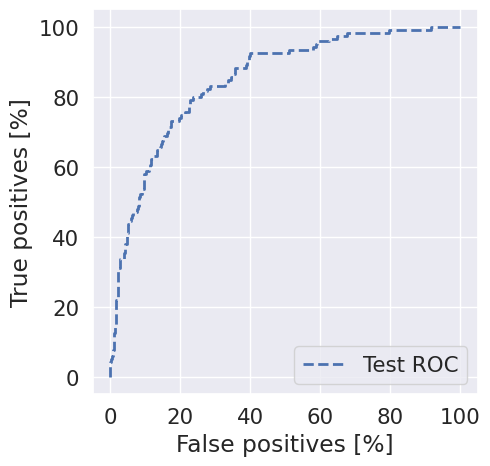

In [373]:
test_predictions = model.predict(test_ds)
test_labels = get_truth_labels(test_ds)


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Test ROC", test_labels, test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [374]:
model.evaluate(train_ds)
model.evaluate(val_ds)
model.evaluate(test_ds)

24/24 [==============================] - 1s 48ms/step - loss: 0.4555 - tp: 5.0000 - fp: 0.0000e+00 - tn: 649.0000 - fn: 114.0000 - accuracy: 0.8516 - precision: 1.0000 - recall: 0.0420 - auc: 0.8408 - prc: 0.5232              


[0.45552968978881836,
 5.0,
 0.0,
 649.0,
 114.0,
 0.8515625,
 1.0,
 0.042016807943582535,
 0.8407958745956421,
 0.5232270359992981]

In [375]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')


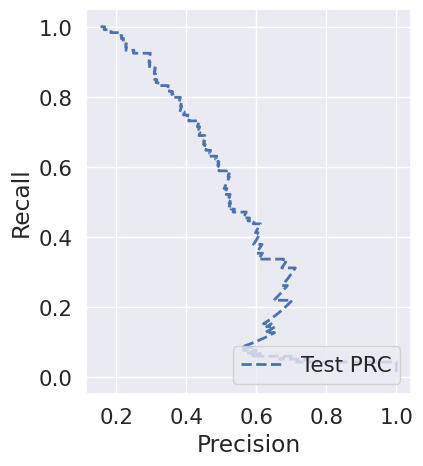

In [376]:
plot_prc("Test PRC", test_labels, test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [250]:
import io

filename = "./efficient_net_weights/efficient_net_weights"
!mkdir "efficient_net_weights"
model.save_weights(filename)
model.load_weights(filename)
!zip -r efficient_net_weights.zip efficient_net_weights


with open('efficient_net_weights.zip', 'rb') as z:
        data = io.BytesIO(z.read())
        project.save_data(
            'efficient_net_weights_transfer_undersample_final.zip', data, set_project_asset=True, overwrite=True
        )

  adding: efficient_net_weights/ (stored 0%)
  adding: efficient_net_weights/checkpoint (deflated 41%)
  adding: efficient_net_weights/efficient_net_weights.data-00000-of-00001 (deflated 7%)
  adding: efficient_net_weights/efficient_net_weights.index (deflated 77%)


24/24 [==============================] - 1s 38ms/step


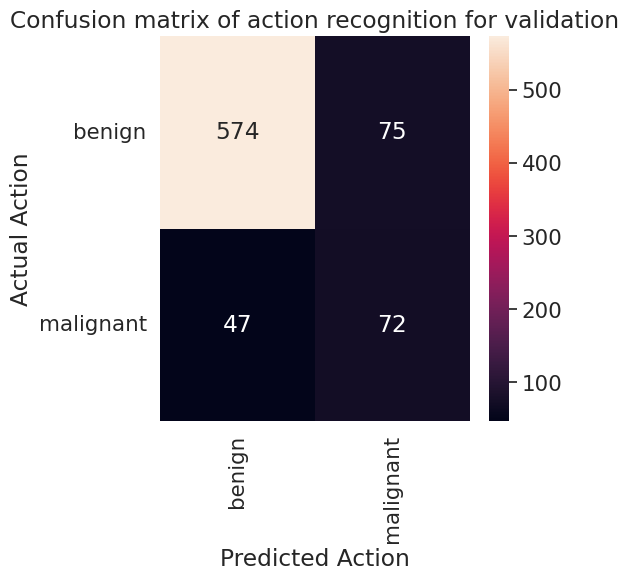

In [385]:
!pip install seaborn
import seaborn as sns
test_predictions = (model.predict(test_ds) > 0.05).astype(int)

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(5, 5)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(test_labels, test_predictions, ["benign", "malignant"], "validation")



In [338]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='MeIrYdYxQFxlcIiqQ5Bq3H2txwCwhhNgOfhZqmj7293w',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'skincancer-donotdelete-pr-mcwsmgkoxtaa7r'
object_key = 'efficient_net_weights_transfer_undersample.zip'

streaming_body_3 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/



In [339]:
get_zip('efficient_net_weights_transfer_undersample.zip')

Files downloaded successfully


In [342]:
!ls -l efficient_net_weights

total 41160
-rw-rw---- 1 wsuser wscommon       99 Jun 19 23:45 checkpoint
-rw-rw---- 1 wsuser wscommon 42107702 Jun 19 23:45 efficient_net_weights.data-00000-of-00001
-rw-rw---- 1 wsuser wscommon    30093 Jun 19 23:45 efficient_net_weights.index


In [344]:
model = get_model()


weight for 0: 1
weight for 1: 0.1
